# Root Cause Analysis for Late Deliveries 

## Feature Significance 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
df = pd.read_excel('CASE STUDY_DATA_LATE DELIVERY ROOT CAUSE.xlsx')

In [3]:
df.head()

,order_id,country,shipping_method,units_per_order,facility,product_category,on_sale,transit_days,returned,backorder,datetime_ordered,datetime_sourced,datetime_product_ready,datetime_planned,datetime_delivered,deadline_source,deadline_make,deadline_deliver,delivered_to_plan
0,E00000001,UNITED KINGDOM,Ground,1,OXFORD,ACCESSORIES,Y,2,NaN,NaN,2016-07-03 03:07:29,2016-07-03 04:09:49,2016-07-06 00:59:42,2016-07-08,2016-07-07,1612,38,3,PASS
1,E00000002,FRANCE,Ground,1,ANTWERP,JACKETS & VESTS,N,3,Y,NaN,2016-07-03 00:08:43,2016-07-03 02:16:24,2016-07-03 07:17:04,2016-07-06,2016-07-05,531,8,3,PASS
2,E00000003,FRANCE,Ground,1,ANTWERP,TOPS,Y,3,NaN,NaN,2016-07-03 00:36:00,2016-07-03 02:16:18,2016-07-03 06:16:57,2016-07-06,2016-07-05,504,8,3,PASS
3,E00000004,FRANCE,Ground,1,ANTWERP,JACKETS & VESTS,Y,5,NaN,NaN,2016-07-03 00:47:45,2016-07-03 02:16:18,2016-07-03 06:16:55,2016-07-07,2016-07-05,492,8,5,PASS
4,E00000005,UNITED KINGDOM,Next Day,1,OXFORD,JACKETS & VESTS,Y,1,NaN,NaN,2016-07-03 03:52:13,2016-07-03 07:56:33,2016-07-05 08:53:19,2016-07-06,2016-07-06,1567,6,1,PASS


In [4]:
df.columns

Index(['order_id', 'country', 'shipping_method', 'units_per_order', 'facility',
       'product_category', 'on_sale', 'transit_days', 'returned', 'backorder',
       'datetime_ordered', 'datetime_sourced', 'datetime_product_ready',
       'datetime_planned', 'datetime_delivered', 'deadline_source',
       'deadline_make', 'deadline_deliver', 'delivered_to_plan'],
      dtype='object')

## Data Cleaning and Preprocessing 

In [5]:
for col in df.columns:
    if df[col].isna().sum()>0:
        print(col, df[col].isna().sum())

returned 94723
backorder 98004


In [6]:
df['returned'].unique()

array([nan, 'Y'], dtype=object)

In [7]:
df['returned'] = df['returned'].fillna('N')

In [8]:
df['backorder'].unique()

array([nan, 'Y'], dtype=object)

In [9]:
df['backorder'] = df['backorder'].fillna('N')

In [10]:
def units(x):
    if(x>=6):
        return 1
    else:
        return 0

In [11]:
df['units>6']=df['units_per_order'].apply(lambda x:units(x))

In [12]:
def final_flag(x):
    if(x=='PASS'):
        return 0
    else:
        return 1

In [13]:
df['final_flag']=df['delivered_to_plan'].apply(lambda x:final_flag(x))

In [14]:
## Encoding Categorical variables
def convert(x):
    if(x=='Y'):
        return 1
    else:
        return 0

In [15]:
df['backorder']=df['backorder'].apply(lambda x:convert(x))
df['returned']=df['returned'].apply(lambda x:convert(x))
df['on_sale'] = df['on_sale'].apply(lambda x:convert(x))

## New Features - Feature Engineering

In [16]:
df['deadline_source'] = pd.to_timedelta(df['deadline_source'],'m')
df['deadline_make']=pd.to_timedelta(df['deadline_make'],'h')
df['deadline_deliver']=pd.to_timedelta(df['deadline_deliver'],'d')

In [17]:
## Actual Sourced Deadline = ordered + source deadline
df['actual_sourced'] = df['datetime_ordered']+df['deadline_source']
df['actual_make'] = df['datetime_sourced']+df['deadline_make']
df['actual_deliver'] = df['datetime_product_ready']+df['deadline_deliver']

In [18]:
df['source_delay'] = df['actual_sourced']-df['datetime_sourced']
df['make_delay']=df['actual_make']-df['datetime_product_ready']
df['delivery_delay'] = df['actual_deliver']-df['datetime_delivered']

In [19]:
def flag(x):
    if(x.days<0):
        return 1
    else:
        return 0

In [20]:
df['source_delay_flag']=df['source_delay'].apply(lambda x:flag(x))
df['make_delay_flag']=df['make_delay'].apply(lambda x:flag(x))
df['delivery_delay_flag']=df['delivery_delay'].apply(lambda x:flag(x))

In [21]:
df['final_flag']=df['delivered_to_plan'].apply(lambda x:final_flag(x))

In [22]:
df['Bad_Plan']=df['source_delay_flag']+df['make_delay_flag']+df['delivery_delay_flag']-df['final_flag']

In [23]:
df['Bad_Plan'].unique()

array([ 1,  0,  2, -1,  3], dtype=int64)

In [24]:
def bad_plan(x):
    if(x<0):
        return 1
    else:
        return 0

In [25]:
df['Bad_Plan']=df['Bad_Plan'].apply(lambda x:bad_plan(x))

In [26]:
df['Delay_Days'] = (df['datetime_delivered']-df['datetime_planned'])

In [27]:
## Converting everything in minutes - Total Delay, source_delay, make_delay, delivery_delay
df['make_delay_minutes']=df['make_delay']/np.timedelta64(1,'m')
df['source_delay_minutes']=df['source_delay']/np.timedelta64(1,'m')
df['delivery_delay_minutes']=df['delivery_delay']/np.timedelta64(1,'m')
df['Total_delay_minutes']=df['Delay_Days']/np.timedelta64(1,'m')


### Linear Model to find the statistical significances

In [28]:
df_new=df.dropna(how='any')
len(df_new)

110114

<b>
From EDA,it was obvious that each of the factors played a significant role in determining the delay. To substantiate this statistically, a Multi Linear Regression model was developed with all the features.
    </b>

In [29]:
## Initial Model
import statsmodels.formula.api as sm
result = sm.ols(formula='Total_delay_minutes ~ country + shipping_method + units_per_order + facility + product_category + on_sale + transit_days + returned + backorder + make_delay_minutes + source_delay_minutes + delivery_delay_minutes + Bad_Plan', data=df_new).fit()

In [30]:
tvals = result.tvalues
tvals = tvals.abs()
tvals = tvals.sort_values(ascending=False)

In [31]:
significant_factors = tvals[tvals>1.96]

In [32]:
print("SIGNIFICANT FACTORS BASED ON t-values")
print("-------------------------------------")
for i in significant_factors.index:
    print(i)

SIGNIFICANT FACTORS BASED ON t-values
-------------------------------------
delivery_delay_minutes
Bad_Plan
make_delay_minutes
country[T.SWEDEN]
shipping_method[T.Ground]
backorder
shipping_method[T.3-Day]
source_delay_minutes
Intercept
facility[T.OXFORD]
facility[T.EINDHOVEN]
facility[T.HANOVER]
facility[T.MANCHESTER]
country[T.GERMANY]
country[T.NETHERLANDS]
country[T.FRANCE]
facility[T.AUGSBURG]
returned
units_per_order
shipping_method[T.Next Day]
product_category[T.JACKETS & VESTS]
on_sale
country[T.UNITED KINGDOM]


In [33]:
insignificant_factors = list(set(result.params.index) - set(significant_factors.index))
insignificant_factors

['product_category[T.TOPS]', 'transit_days']

In [35]:
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Total_delay_minutes   R-squared:                       0.541
Model:                             OLS   Adj. R-squared:                  0.541
Method:                  Least Squares   F-statistic:                     5907.
Date:                 Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                         23:10:55   Log-Likelihood:            -9.8166e+05
No. Observations:               110114   AIC:                         1.963e+06
Df Residuals:                   110091   BIC:                         1.964e+06
Df Model:                           22                                         
Covariance Type:             nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [36]:
## After removing insiginificant factors
result = sm.ols(formula='Total_delay_minutes ~ country + shipping_method + units_per_order + facility  + on_sale  + returned + backorder + make_delay_minutes + source_delay_minutes + delivery_delay_minutes + Bad_Plan', data=df_new).fit()

In [37]:
print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     Total_delay_minutes   R-squared:                       0.541
Model:                             OLS   Adj. R-squared:                  0.541
Method:                  Least Squares   F-statistic:                     6838.
Date:                 Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                         23:11:02   Log-Likelihood:            -9.8167e+05
No. Observations:               110114   AIC:                         1.963e+06
Df Residuals:                   110094   BIC:                         1.964e+06
Df Model:                           19                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercep

In [39]:
tvals = result.tvalues
tvals = abs(tvals)
tvals.sort_values(ascending=False)

delivery_delay_minutes         316.014963
Bad_Plan                        76.793212
make_delay_minutes              63.379863
country[T.SWEDEN]               46.518136
shipping_method[T.Ground]       32.013992
Intercept                       27.415664
shipping_method[T.3-Day]        26.877619
backorder                       26.558182
source_delay_minutes            25.227989
facility[T.OXFORD]              21.052605
facility[T.EINDHOVEN]           20.680475
facility[T.HANOVER]             18.614339
facility[T.MANCHESTER]          15.697079
country[T.GERMANY]              14.890774
country[T.NETHERLANDS]          10.021757
country[T.FRANCE]                9.104713
facility[T.AUGSBURG]             7.335590
returned                         4.609329
units_per_order                  4.406303
shipping_method[T.Next Day]      4.238808
on_sale                          2.487003
country[T.UNITED KINGDOM]        2.472673
dtype: float64

<b>
Clearly, by the absolute values of the t-values, Delivery Delay and Make Delay are significantly important. Bad Planning is also a significant factor contributing to the failure in delivery.

The intercept value is an aggregation of values when country is Belgium, Shipping method is 2- Day and Facility is Antwerp.  Having a significant t value, all these factors are also contributing significantly towards the failure in delivery. Therefore, a conclusion that was made in the preliminary analysis of data is thus justified.
</b>


### Correlation check to avoid multi-collinearity

In [40]:
cols=['country', 'shipping_method','units_per_order','facility',
'on_sale','returned','backorder','make_delay_minutes','source_delay_minutes','delivery_delay_minutes',
'Bad_Plan']
len(cols)

11

In [41]:
df_corr= df_new[cols].corr()
df_corr

,units_per_order,on_sale,returned,backorder,make_delay_minutes,source_delay_minutes,delivery_delay_minutes,Bad_Plan
units_per_order,1.000000,0.008649,-0.008314,0.070296,-0.013211,-0.027145,0.002599,-0.006303
on_sale,0.008649,1.000000,-0.002524,0.026867,-0.034179,-0.015117,0.033117,-0.016652
returned,-0.008314,-0.002524,1.000000,-0.013449,-0.049228,-0.007190,-0.025912,-0.008470
backorder,0.070296,0.026867,-0.013449,1.000000,-0.052459,-0.168996,0.087753,0.003788
make_delay_minutes,-0.013211,-0.034179,-0.049228,-0.052459,1.000000,0.238675,-0.212736,0.046050
source_delay_minutes,-0.027145,-0.015117,-0.007190,-0.168996,0.238675,1.000000,-0.122751,0.010547
delivery_delay_minutes,0.002599,0.033117,-0.025912,0.087753,-0.212736,-0.122751,1.000000,-0.067253
Bad_Plan,-0.006303,-0.016652,-0.008470,0.003788,0.046050,0.010547,-0.067253,1.000000


<b>
Thus, none of the selected features are higly correlated, eliminating the problem of multi collinearity. 
</b>

In [42]:
set(cols)-set(df_corr.index)

{'country', 'facility', 'shipping_method'}

In [43]:
## Sub-sampling the points for seeing any anomolies in the data
df_temp=df_new.sample(10000)

In [44]:
## After removing insiginificant factors
result = sm.ols(formula='Total_delay_minutes ~ country + shipping_method + units_per_order + facility  + on_sale  + returned + backorder + make_delay_minutes + source_delay_minutes + delivery_delay_minutes + Bad_Plan', data=df_temp).fit()

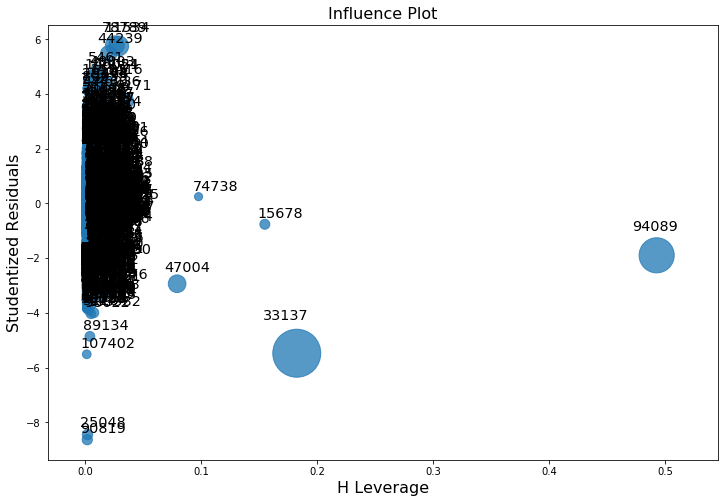

In [45]:
import statsmodels.api as sg
fig, ax = plt.subplots(figsize=(12,8))
fig = sg.graphics.influence_plot(result, ax=ax, criterion="cooks")

<b>
Clearly, there are many outliers for which we need a robust model that would not get affected by these high leverage points.
Since there are many outliers in the data, adding data would lead to a poor model with poor R2. Therefore, we can use a sample of 50000 points to find the significant features/causes. 

Our primary goal through this linear model is to find the significance of each feature and their role in determining the cause in the delay. Therefore, with stats model linear models being more interpretable( in terms of significance), this package was chosen over other packages(sklearn Linear Regression).
</b>

In [46]:
df_temp=df_new.sample(50000)
tdf = df_temp[cols]
df_fitted_vs_actual = pd.DataFrame()
df_fitted_vs_actual['Actual'] = df_temp['Total_delay_minutes']
df_fitted_vs_actual['Predicted'] = result.predict(exog = tdf)
df_fitted_vs_actual['Residuals'] = df_fitted_vs_actual['Actual']-df_fitted_vs_actual['Predicted']
df_fitted_vs_actual.head()

,Actual,Predicted,Residuals
73395,-5760.0,-4903.408675,-856.591325
92775,-1440.0,-1469.869730,29.869730
8676,0.0,-1056.529397,1056.529397
4126,0.0,-225.929459,225.929459
8956,-8640.0,-3565.061473,-5074.938527


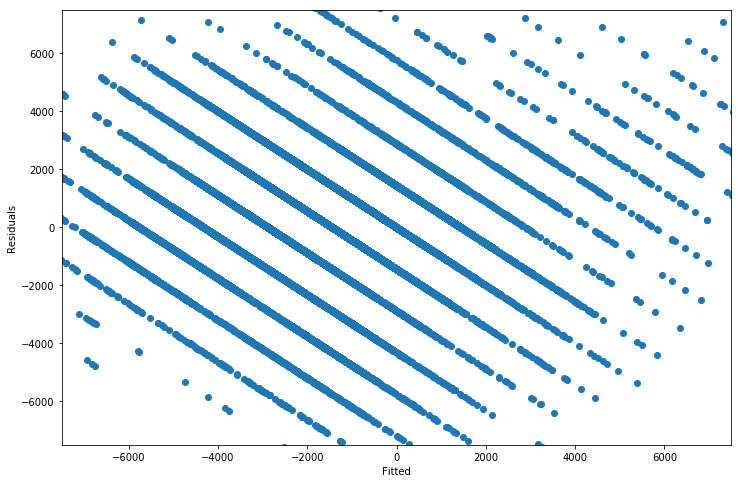

In [47]:
plt.figure(figsize=(12,8))
plt.xlim(-7500,7500)
plt.ylim(-7500, 7500)
plt.xlabel("Fitted")
plt.ylabel("Residuals")
plt.scatter(df_fitted_vs_actual['Predicted'],df_fitted_vs_actual['Residuals'])

### For finding the model with interactions
Though each of the factors are not correlated to each other, there might be some interactions that can give a better reasoning for delay. This can be explored by trying all the possible interactions. 

In [48]:
from itertools import combinations_with_replacement 
comb_1=combinations_with_replacement(cols, 1)
comb_2 = combinations_with_replacement(cols, 2)
all_comb = list(comb_1)+list(comb_2)

We are using adjusted r2 as the metric to include a term in the model or not. If there is an increase in the adjusted r2 value, the term is included, otherwise the term is ignored.

In [49]:
adjusted_r2=[]
appended_comb = []
ignored_comb = []
formula_string = 'Total_delay_minutes ~ '
for comb in all_comb:
    temp_string = formula_string
    if(len(comb)==1):
        formula_string += ' + '+ comb[0]
        
    elif(len(comb)==2):
        if(comb[0]==comb[1]):
            formula_string += ' + '+comb[0]+'**'+'2'
        else:
            formula_string +=' + '+comb[0] +'*'+ comb[1]

    result = sm.ols(formula=formula_string , data=df_temp).fit()
    if(len(adjusted_r2)<1):
        adjusted_r2.append(result.rsquared_adj)
        appended_comb.append(comb)
    else:
        if(adjusted_r2[-1]>result.rsquared_adj):
            ignored_comb.append(comb)
            formula_string=temp_string
        else:
            appended_comb.append(comb)
            adjusted_r2.append(result.rsquared_adj)

In [50]:
ignored_comb

[('source_delay_minutes',),
 ('shipping_method', 'units_per_order'),
 ('shipping_method', 'returned'),
 ('units_per_order', 'make_delay_minutes'),
 ('units_per_order', 'Bad_Plan'),
 ('facility', 'returned'),
 ('on_sale', 'Bad_Plan'),
 ('source_delay_minutes', 'delivery_delay_minutes')]

Text(0,0.5,'Adjusted R2')

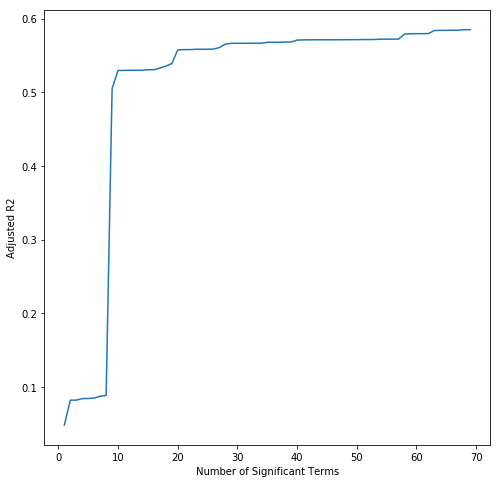

In [52]:
plt.figure(figsize=(8,8))
plt.plot(range(1,len(adjusted_r2)+1),adjusted_r2)
plt.xlabel("Number of Significant Terms")
plt.ylabel("Adjusted R2")

In [53]:
## With the final formula string
result = sm.ols(formula=formula_string , data=df_temp).fit()

In [54]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total_delay_minutes   R-squared:                       0.586
Model:                             OLS   Adj. R-squared:                  0.585
Method:                  Least Squares   F-statistic:                     522.7
Date:                 Mon, 15 Oct 2018   Prob (F-statistic):               0.00
Time:                         23:20:51   Log-Likelihood:            -4.4279e+05
No. Observations:                50000   AIC:                         8.859e+05
Df Residuals:                    49864   BIC:                         8.871e+05
Df Model:                          135                                         
Covariance Type:             nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                              1111.6068    226.715      4.903      0.000     667.244    1555.970
country[T.FRANCE]                                       597.7842    203.732      2.934      0.003     198.468     997.101
country[T.GERMANY]                                     -650.3124    309.752     -2.099      0.036   -1257.429     -43.196
country[T.NETHERLANDS]                                  452.6912    186.915      2.422      0.015      86.335     819.047
country[T.SWEDEN]                                     -2232.6225    203.162    -10.989      0.000   -2630.822   -1834.423
country[T.UNITED KINGDOM]                               236.4537    137.877      1.715      0.086     -33.787     506.694
shipping_method[T.3-Day]                               -357.5163     47.184     -7.577      0.000    -449.998    -265.035
shipping_method[T.Ground]                              -359.1954    189.238     -1.898      0.058    -730.104      11.713
shipping_method[T.Next Day]                            -123.2861     96.766     -1.274      0.203    -312.948      66.376
facility[T.AUGSBURG]                                    -52.0159     65.652     -0.792      0.428    -180.694      76.662
facility[T.EINDHOVEN]                                  1778.1212    504.320      3.526      0.000     789.648    2766.594
facility[T.HANOVER]                                     331.1950     72.804      4.549      0.000     188.499     473.891
facility[T.MANCHESTER]                                 -890.8873    228.124     -3.905      0.000   -1338.013    -443.761
facility[T.OXFORD]                                     -652.5904    204.537     -3.191      0.001   -1053.485    -251.696
country[T.FRANCE]:shipping_method[T.3-Day]            -3.719e-07   1.58e-07     -2.359      0.018   -6.81e-07   -6.29e-08
country[T.GERMANY]:shipping_method[T.3-Day]            -357.5163     47.184     -7.577      0.000    -449.998    -265.035
country[T.NETHERLANDS]:shipping_method[T.3-Day]       -2.744e-08   9.29e-08     -0.295      0.768    -2.1e-07    1.55e-07
country[T.SWEDEN]:shipping_method[T.3-Day]            -5.195e-09   1.48e-09     -3.513      0.000   -8.09e-09    -2.3e-09
country[T.UNITED KINGDOM]:shipping_method[T.3-Day]    -2.284e-08   4.41e-09     -5.181      0.000   -3.15e-08   -1.42e-08
country[T.FRANCE]:shipping_method[T.Ground]             279.0280    189.853      1.470      0.142     -93.085     651.141
country[T.GERMANY]:shipping_method[T.Ground]          -1613.0749    358.930     -4.494      0.000   -2316.581    -909.568
country[T.NETHERLANDS]:shipping_method[T.Ground]        646.4612    173.367      3.729      0.000     306.659     986.263
country[T.SWEDEN]:ship

In [55]:
significant_factors = result.params[(result.tvalues<-1.96)].index
significant_factors= significant_factors.append(result.params[(result.tvalues>1.96)].index)
len(significant_factors)

106

In [56]:
insignificant_factors = list(set(result.params.index) - set(significant_factors))
len(insignificant_factors)

88

In [57]:
significant_factors

Index(['country[T.GERMANY]', 'country[T.SWEDEN]', 'shipping_method[T.3-Day]',
       'facility[T.MANCHESTER]', 'facility[T.OXFORD]',
       'country[T.FRANCE]:shipping_method[T.3-Day]',
       'country[T.GERMANY]:shipping_method[T.3-Day]',
       'country[T.SWEDEN]:shipping_method[T.3-Day]',
       'country[T.UNITED KINGDOM]:shipping_method[T.3-Day]',
       'country[T.GERMANY]:shipping_method[T.Ground]',
       ...
       'country[T.UNITED KINGDOM]:source_delay_minutes',
       'facility[T.MANCHESTER]:source_delay_minutes',
       'units_per_order:returned', 'on_sale:delivery_delay_minutes',
       'returned:backorder', 'backorder:source_delay_minutes',
       'backorder:delivery_delay_minutes', 'make_delay_minutes:Bad_Plan',
       'source_delay_minutes:Bad_Plan', 'delivery_delay_minutes:Bad_Plan'],
      dtype='object', length=106)

In [58]:
tvalues = result.tvalues
tvalues = abs(tvalues)
tvalues.sort_values(ascending=False)[:15]

delivery_delay_minutes                                28.313435
backorder:source_delay_minutes                        28.193238
make_delay_minutes:delivery_delay_minutes             22.061332
country[T.FRANCE]:delivery_delay_minutes              19.197849
shipping_method[T.Next Day]:delivery_delay_minutes    14.196831
units_per_order:source_delay_minutes                  13.980866
country[T.FRANCE]:make_delay_minutes                  11.957268
country[T.SWEDEN]:shipping_method[T.Ground]           10.989377
country[T.SWEDEN]                                     10.989377
shipping_method[T.Next Day]:source_delay_minutes       9.550980
country[T.SWEDEN]:on_sale                              9.507899
delivery_delay_minutes:Bad_Plan                        9.411845
country[T.SWEDEN]:delivery_delay_minutes               8.768673
facility[T.EINDHOVEN]:delivery_delay_minutes           8.469219
facility[T.AUGSBURG]:make_delay_minutes                8.024433
dtype: float64

<b>
These top significant factors clearly substantiate our conclusions from the preliminary analysis. 

1. Delivery delay and make delay are associated with each other ( both of them being consecutive steps) and together act as a significant cause for the failure in delivery.
2. Backorder and the source delay are directly related. They together play an important role in failure. Backorder is also highly associated with Bad Planning.
3. For a product on sale, when the shipping method is Ground, with Next-Day or a 2-Day Delivery, the delay is usually high.
</b>

### Classification - Decision Tree and Logistic Classification

In this scenario, we would like to develop a model to check the prediction of delay , just based on order attributes, without considering the time delays. This might aid in developing better recommendations/ rule for planning the deliveries.

Therefore, a supervised learning - classification approach was used to develop a model.

In [59]:
#### Machine Learning
df_classification=df_new.drop(['order_id','datetime_ordered','datetime_sourced',
         'datetime_product_ready','datetime_planned',
         'datetime_delivered', 'units_per_order',
        'deadline_source','datetime_product_ready','datetime_planned',
         'datetime_delivered','deadline_source','deadline_make',
        'actual_sourced', 'actual_make', 'actual_deliver',
        'source_delay', 'make_delay', 'delivery_delay', 'source_delay_flag',
       'make_delay_flag', 'delivery_delay_flag','Delay_Days','final_flag','deadline_deliver'],axis=1)


In [60]:
df_classification.columns

Index(['country', 'shipping_method', 'facility', 'product_category', 'on_sale',
       'transit_days', 'returned', 'backorder', 'delivered_to_plan', 'units>6',
       'Bad_Plan', 'make_delay_minutes', 'source_delay_minutes',
       'delivery_delay_minutes', 'Total_delay_minutes'],
      dtype='object')

In [61]:
len(df_classification)

110114

In [62]:
df_1 = df[df.delivered_to_plan == 'PASS']
df_2 = df[df.delivered_to_plan == 'FAIL']
print('Number of succesful cases',len(df_1))
print('Number of failure cases',len(df_2))

## Imbalanced Data - subsampling
df_equal = pd.concat([df_2,df_1.sample(len(df_2))])
df_equal=df_equal[df_classification.columns]
df_equal.head()

Number of succesful cases 98523
Number of failure cases 11591


,country,shipping_method,facility,product_category,on_sale,transit_days,returned,backorder,delivered_to_plan,units>6,Bad_Plan,make_delay_minutes,source_delay_minutes,delivery_delay_minutes,Total_delay_minutes
42,FRANCE,Ground,ANTWERP,JACKETS & VESTS,1,3,0,0,FAIL,0,0,360.600000,-17.983333,1696.783333,1440.0
44,FRANCE,Ground,ANTWERP,JACKETS & VESTS,0,4,0,0,FAIL,0,0,299.733333,-77.716667,1757.016667,1440.0
50,GERMANY,3-Day,AUGSBURG,JACKETS & VESTS,1,3,0,0,FAIL,0,1,2819.550000,2717.616667,222.666667,1440.0
56,GERMANY,Ground,AUGSBURG,JACKETS & VESTS,1,2,0,0,FAIL,0,1,2809.733333,2787.383333,222.783333,1440.0
57,GERMANY,3-Day,AUGSBURG,JACKETS & VESTS,0,3,1,0,FAIL,0,0,2809.633333,2786.500000,-5537.100000,7200.0


In [63]:
df_classification.dtypes

country                    object
shipping_method            object
facility                   object
product_category           object
on_sale                     int64
transit_days                int64
returned                    int64
backorder                   int64
delivered_to_plan          object
units>6                     int64
Bad_Plan                    int64
make_delay_minutes        float64
source_delay_minutes      float64
delivery_delay_minutes    float64
Total_delay_minutes       float64
dtype: object

In [64]:
df_equal = pd.get_dummies(df_equal, columns= ['country','shipping_method',
                                  'facility','product_category'])
df_equal.head()

,on_sale,transit_days,returned,backorder,delivered_to_plan,units>6,Bad_Plan,make_delay_minutes,source_delay_minutes,delivery_delay_minutes,...,shipping_method_Next Day,facility_ANTWERP,facility_AUGSBURG,facility_EINDHOVEN,facility_HANOVER,facility_MANCHESTER,facility_OXFORD,product_category_ACCESSORIES,product_category_JACKETS & VESTS,product_category_TOPS
42,1,3,0,0,FAIL,0,0,360.600000,-17.983333,1696.783333,...,0,1,0,0,0,0,0,0,1,0
44,0,4,0,0,FAIL,0,0,299.733333,-77.716667,1757.016667,...,0,1,0,0,0,0,0,0,1,0
50,1,3,0,0,FAIL,0,1,2819.550000,2717.616667,222.666667,...,0,0,1,0,0,0,0,0,1,0
56,1,2,0,0,FAIL,0,1,2809.733333,2787.383333,222.783333,...,0,0,1,0,0,0,0,0,1,0
57,0,3,1,0,FAIL,0,0,2809.633333,2786.500000,-5537.100000,...,0,0,1,0,0,0,0,0,1,0


In [65]:
len(df_equal)

23182

### Model Selection and Model Tuning

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

C:\Users\pooji\Anaconda3_new\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [67]:
df_equal.columns

Index(['on_sale', 'transit_days', 'returned', 'backorder', 'delivered_to_plan',
       'units>6', 'Bad_Plan', 'make_delay_minutes', 'source_delay_minutes',
       'delivery_delay_minutes', 'Total_delay_minutes', 'country_BELGIUM',
       'country_FRANCE', 'country_GERMANY', 'country_NETHERLANDS',
       'country_SWEDEN', 'country_UNITED KINGDOM', 'shipping_method_2-Day',
       'shipping_method_3-Day', 'shipping_method_Ground',
       'shipping_method_Next Day', 'facility_ANTWERP', 'facility_AUGSBURG',
       'facility_EINDHOVEN', 'facility_HANOVER', 'facility_MANCHESTER',
       'facility_OXFORD', 'product_category_ACCESSORIES',
       'product_category_JACKETS & VESTS', 'product_category_TOPS'],
      dtype='object')

In [68]:
y = df_equal.delivered_to_plan
y.unique()

array(['FAIL', 'PASS'], dtype=object)

In [69]:
del df_equal['delivered_to_plan']

In [70]:
y_1=[]
for i in range(0,len(y)):
    if y.iloc[i] == 'PASS':
        y_1.append(1)
    else:
        y_1.append(0)

In [71]:
y = pd.Series(y_1)

When the time lag is used, the accuracy is obviously very high. But we are interested in finding the dependency and the reasons behind lag, so we are ignoring the time lags in our model

In [72]:
df_equal.drop(['make_delay_minutes', 'source_delay_minutes',
       'delivery_delay_minutes', 'Total_delay_minutes'],axis=1,inplace=True)


In [73]:
df_equal.drop(['Bad_Plan'],axis=1,inplace=True)
df_equal.head()

,on_sale,transit_days,returned,backorder,units>6,country_BELGIUM,country_FRANCE,country_GERMANY,country_NETHERLANDS,country_SWEDEN,...,shipping_method_Next Day,facility_ANTWERP,facility_AUGSBURG,facility_EINDHOVEN,facility_HANOVER,facility_MANCHESTER,facility_OXFORD,product_category_ACCESSORIES,product_category_JACKETS & VESTS,product_category_TOPS
42,1,3,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
44,0,4,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
50,1,3,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
56,1,2,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
57,0,3,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_equal, y, test_size = 0.4, random_state=10)

dec_clf = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dec_clf.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.5924727704087135


This model can further be tuned to find optimal hyper parameters.

In [75]:
from sklearn.cross_validation import cross_val_score
depth = []
for i in range(3,20):
    clf = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5, n_jobs=4)
    depth.append(scores.mean())

C:\Users\pooji\Anaconda3_new\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Text(0,0.5,'Accuracy')

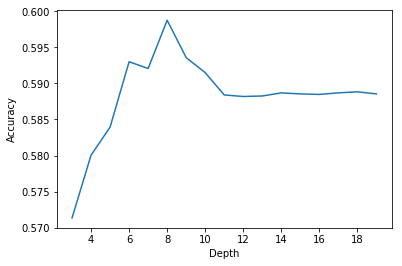

In [81]:
plt.plot(range(3,20),depth)
plt.xlabel('Depth')
plt.ylabel('Accuracy')

In [77]:
best_depth = range(3,20)[np.argmax(depth)]

In [78]:
dec_clf = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)
y_pred = dec_clf.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.5985118084762213


In [79]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(accuracy_score(y_pred,y_test))


0.5906394909953628


In [80]:
depth_scores = []
for i in range(3,20):
    rf_clf = RandomForestClassifier(max_depth=i)
    scores = cross_val_score(estimator=rf_clf, X=X_train, y=y_train, cv=5, n_jobs=4)
    depth_scores.append(scores.mean())
    

Text(0,0.5,'Accuracy')

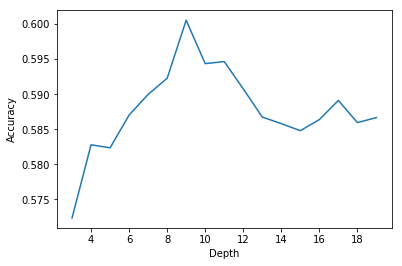

In [82]:
plt.plot(range(3,20),depth_scores)
plt.xlabel('Depth')
plt.ylabel('Accuracy')

In [85]:
best_depth_rf = range(3,20)[np.argmax(depth_scores)]
depth_scores[best_depth_rf]

0.5907693536152034

In [84]:
rf_clf = RandomForestClassifier(max_depth=best_depth_rf).fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(accuracy_score(y_pred,y_test))

0.5957079693734498


In [86]:
from sklearn.linear_model import LogisticRegression
m = LogisticRegression().fit(X_train,y_train)
y_pred_logit = m.predict(X_test)

In [87]:
print(m.coef_)

[[-0.0180733   0.2648662  -0.15566493 -0.82698187 -0.16083607 -0.51861489
  -0.14349932  0.09598554  0.12441696 -0.27416943  0.27043084 -0.56324596
  -0.08609505  0.25574441 -0.05185369 -0.14349932 -0.04510822 -0.32846872
  -0.0490524   0.07573064  0.04494774 -0.07819994 -0.19977988 -0.16747046]]


In [88]:
print(accuracy_score(y_pred_logit,y_test))

0.5907473309608541


In [89]:
C_vals= [0.001, 0.01, 0.1, 1, 10, 100, 1000] 

In [90]:
Cs=[]
for i in C_vals:
    m = LogisticRegression(C=i)
    scores = cross_val_score(estimator=m, X=X_train, y=y_train, cv=5, n_jobs=4)
    Cs.append(scores.mean())

In [91]:
best_C = C_vals[np.argmax(Cs)]
best_C

100

In [92]:
m = LogisticRegression(C=best_C).fit(X_train,y_train)
y_pred_logit = m.predict(X_test)
print(accuracy_score(y_pred_logit,y_test))

0.5904238110643805


### Conclusions
Clearly, Inspite of using boosted ensemble models also, the model accuracy is not high. This is  because of lack of appropriate data. We would need better data that can include the details about the distance between the source and destination- for each step.

